In [1]:
!pip install -q transformers


In [2]:
!pip install git+https://github.com/huggingface/accelerate.git

  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-req-build-3rgxcez2
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-req-build-3rgxcez2

  Resolved https://github.com/huggingface/accelerate.git to commit b634388ef1e5d3631e88fdc08eda321c1c69e874
  Installing build dependencies ... -

done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install diffusers transformers scipy safetensors


In [4]:
!pip install opencv-python


In [5]:
import matplotlib.pyplot as plt
import cv2
import copy
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ToPILImage

from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation



In [6]:

def read_image(image_name, image_extension):
  image = cv2.imread(f"{image_name}.{image_extension}" )
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = torch.tensor(image)
  plt.figure(figsize=(5,5))
  plt.imshow(image)
  plt.axis('on')
  plt.show()
  return image

def merge_images(image, shifted_image, shifted_mask):
    binary_mask = (shifted_mask > 0).float()
    merged_image = image.clone()

    for channel in range(3):  # Loop through each color channel
        merged_image[..., channel] = image[..., channel] * (1 - binary_mask) + shifted_image[..., channel]/255 * binary_mask
    return merged_image



def resize_image(image, shape, n_channel):
  output_size = shape
  if n_channel == 1:
    image = image.unsqueeze(-1)

  image_permute = image.permute(2,0,1)
  resized_image_3d_tensor = torch.nn.functional.interpolate(image_permute.unsqueeze(0), size=output_size, mode='bilinear', align_corners=False).squeeze(0)
  resized_image_3d_tensor = resized_image_3d_tensor.permute(1,2,0)

  if n_channel == 1:
    resized_image_3d_tensor = resized_image_3d_tensor.squeeze(-1)
  return resized_image_3d_tensor
def move_content(image,mask, x_shift, y_shift):
    height, width = mask.shape
    shifted_image = image
    shifted_mask = torch.zeros_like(mask)
    for y in range(height):
        for x in range(width):
            if mask[y, x] == 1:
                new_x = min(width - 1, max(0, x + x_shift))  # Ensure new_x is within bounds
                new_y = min(height - 1, max(0, y - y_shift))  # Ensure new_y is within bounds

                shifted_mask[new_y, new_x] = 1
                shifted_image[new_y,new_x,0] = shifted_image[y,x,0]
                shifted_image[new_y,new_x,1] = shifted_image[y,x,1]
                shifted_image[new_y,new_x,2] = shifted_image[y,x,2]
                shifted_image[y,x,0] = 0
                shifted_image[y,x,1] = 0
                shifted_image[y,x,2] = 0

    return shifted_image, shifted_mask



def add_padding_mask(mask, k):
    # Create a kernel representing the neighborhood around each one
    kernel_size = 2 * k + 1
    kernel = torch.ones(1, 1, kernel_size, kernel_size, dtype=torch.float32).to(mask.device)

    # Use 2D convolution to surround each one with ones
    surrounded_tensor = F.conv2d(mask.unsqueeze(0).unsqueeze(0).float(), kernel, padding=k).squeeze().byte()
    surrounded_tensor = (surrounded_tensor > 0).to(float)

    return surrounded_tensor



def apply_mask_to_image(image, mask, opacity=0.4):
    # Convert mask to red overlay
    red_overlay = torch.zeros_like(image, dtype=torch.float32)
    red_overlay[mask >= .9] = torch.tensor([1.0, 0.0, 0], dtype=torch.float32)  # Set red color where mask is 1
    
    # Blend the original image and the red overlay using alpha blending
    masked_image =  image/255 + opacity * red_overlay
    # masked_image = torch.tensor(masked_image*255, dtype = torch.uint8)
    return masked_image

    # # Example usage
    # image_tensor = image  # Example 3D image tensor
    # binary_mask = discrete_mask  # Example 2D binary mask

    # # Apply mask to image
    # masked_image = apply_mask_to_image(image_tensor, binary_mask)

    # # Display the masked image (you can use any method to display or save tensor as image)
    # plt.imshow(masked_image)


def tensor_to_pil(tensor):
  to_pil = ToPILImage()
  temp_image = None
  if tensor.dim() == 3:
    temp_image = tensor.permute(2,0,1)
    temp_image = to_pil(temp_image)
  elif tensor.dim() ==2:
    temp_image = to_pil(tensor)
  return temp_image


In [70]:

def load_segment_pipeline():
  processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
  model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
  return processor, model

def get_mask(image, prompts, processor, model):
  inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
  # predict
  with torch.no_grad():
    outputs = model(**inputs)
    print(outputs.logits.size())

  preds = outputs.logits
  if outputs.logits.dim() == 2:
    preds = outputs.logits.unsqueeze(0)
  return preds[0]

def load_inpaint_pipeline():
  # stabilityai/stable-diffusion-2-inpainting
  # pipeline = AutoPipelineForInpainting.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16, variant="fp16").to("cuda")
  pipeline = AutoPipelineForInpainting.from_pretrained("stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16, variant="fp16").to("cuda")

  pipeline.enable_model_cpu_offload()
  return pipeline

def inpaint_image(pipeline, prompt, image, mask, temperature, strength, guidance_scale, negative_prompt):
  pipeline.config.temperature = temperature
  inpaint_image = pipeline(prompt=prompt, image=image, mask_image=mask, strength = strength, guidance_scale = guidance_scale, negative_prompt = negative_prompt).images[0]
  return inpaint_image



In [71]:
processor, model = load_segment_pipeline()
pipeline = load_inpaint_pipeline()


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

(…)diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

(…)diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

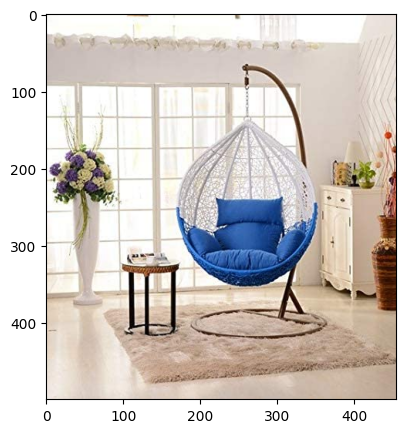

Unused or unrecognized kwargs: padding.


torch.Size([1, 352, 352])


In [166]:
image_name = "stool"
image_extension = 'jpeg'
mask_prompt = [image_name]
image = read_image(image_name = image_name, image_extension = image_extension)

mask = get_mask(image = image, prompts = mask_prompt, processor = processor, model = model)



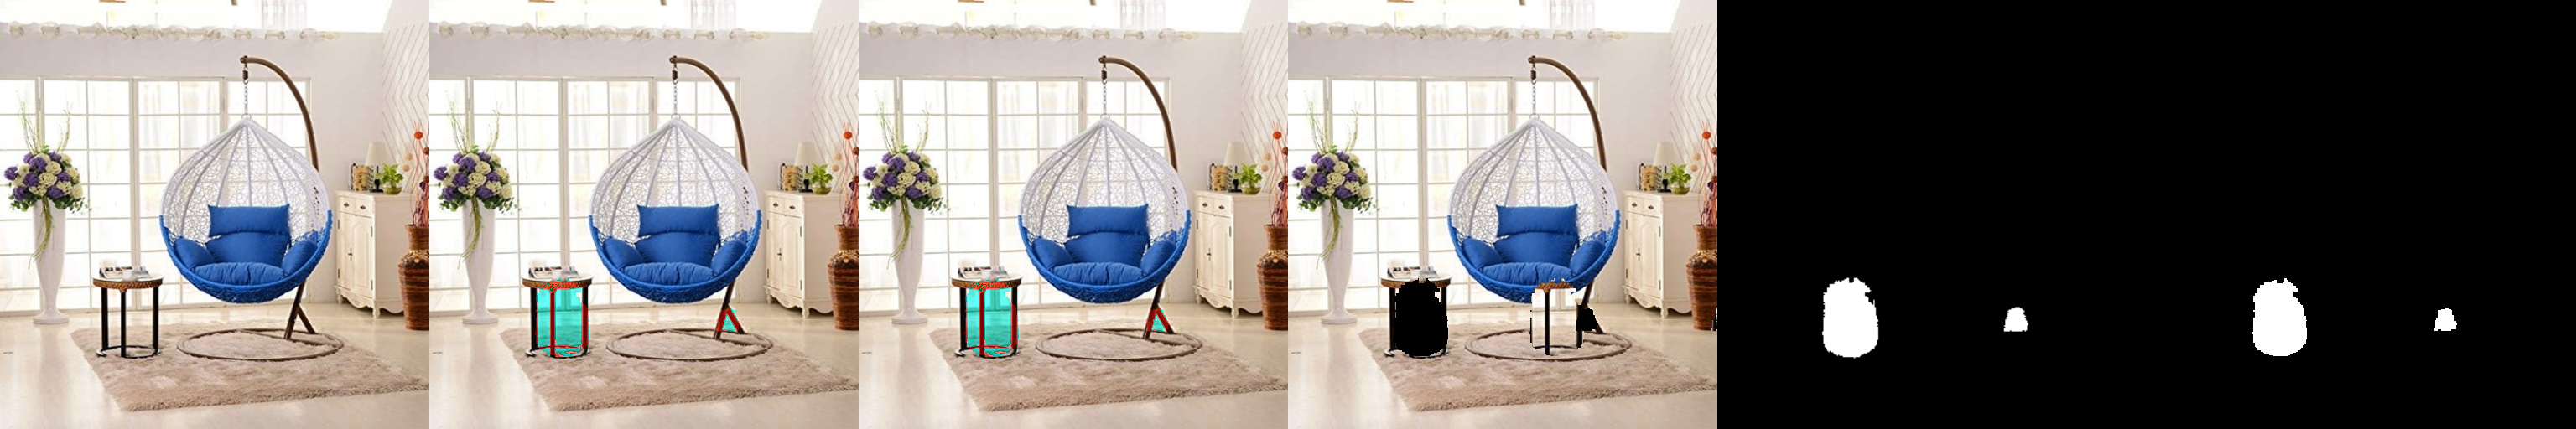

In [174]:

x_shift = 162
y_shift = 0
mask_pad = 0

discrete_mask = (mask >= .6).to(torch.float)
image = resize_image(image, shape = (512,512), n_channel = 3)
discrete_mask = resize_image(discrete_mask, shape = (512,512), n_channel = 1)

shifted_image, shifted_mask = move_content(image = copy.deepcopy(image), mask = discrete_mask, x_shift = x_shift, y_shift=y_shift)



discrete_mask_padded = add_padding_mask(discrete_mask, k = mask_pad)

masked_image = apply_mask_to_image(image, discrete_mask)
masked_image_padded = apply_mask_to_image(image, discrete_mask_padded)


pil_image = tensor_to_pil(image)
pil_mask = tensor_to_pil(discrete_mask)
pil_mask_padded = tensor_to_pil(discrete_mask_padded)
pil_masked_image = tensor_to_pil(masked_image)
pil_masked_image_padded = tensor_to_pil(masked_image_padded)
pil_shifted_image = tensor_to_pil(shifted_image)
pil_shifted_mask = tensor_to_pil(shifted_mask)

make_image_grid([pil_image,pil_masked_image,pil_masked_image_padded, pil_shifted_image,pil_mask, pil_mask_padded], rows=1, cols=6)
# make_image_grid([pil_image,pil_masked_image,pil_masked_image_padded, pil_shifted_image,pil_mask, pil_mask_padded], rows=1, cols=6)

  0%|          | 0/50 [00:00<?, ?it/s]

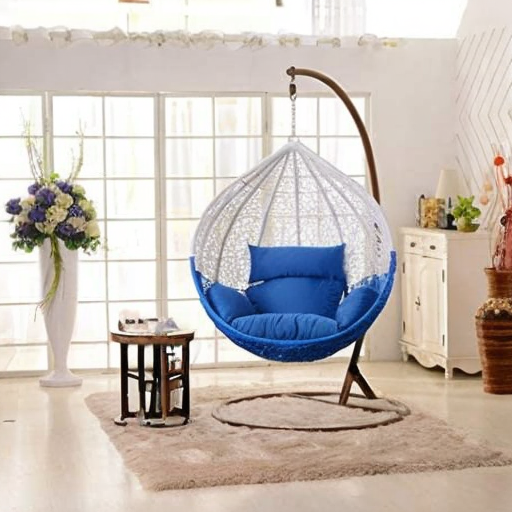

In [178]:
# inpaint_prompt = ""
# temperature = .5
# strength = 1
# guidance_scale = .1
# negative_prompt = ""
inpaint_prompt = ""
temperature = .4
strength = 1
guidance_scale = 2
negative_prompt = ""
final_image = inpaint_image(pipeline, prompt = inpaint_prompt, image = pil_image, mask = pil_mask_padded, temperature = temperature, strength = strength, guidance_scale = guidance_scale, negative_prompt = negative_prompt)
final_image

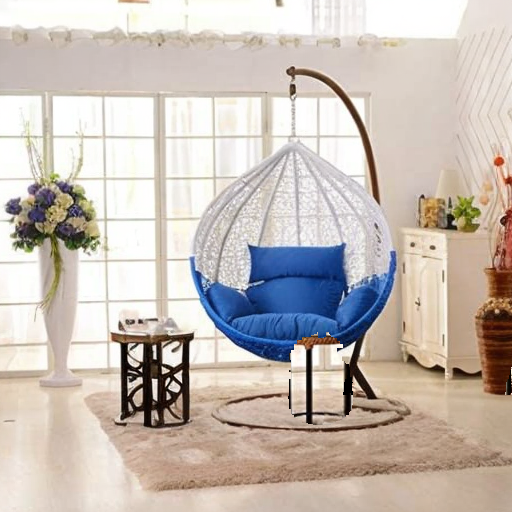

In [176]:


transform = transforms.ToTensor()
tensor_image = transform(final_image)
tensor_image = tensor_image.permute(1,2,0)
merged_image = merge_images(tensor_image, shifted_image, shifted_mask)
merged_image = tensor_to_pil(merged_image)
merged_image

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2lodboo1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2lodboo1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=d860c7d49dd3670062275e0712b1a3ba3200fd590e4d20de6b98e1a5e907e27e
  Stored in directory: /tmp/pip-ephem-wheel-cache-p3_0r8sm/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-03-27 14:26:24--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.18.103, 13.35.18.102, 13.35.18.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.18.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   103MB/s    in 18s     

2024-03-27 14:26:42 (137 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator

checkpoint = 'sam_vit_h_4b8939.pth'
model_type = 'vit_h'
sam = sam_model_registry[model_type](checkpoint=checkpoint)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam.to(device=device)



Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

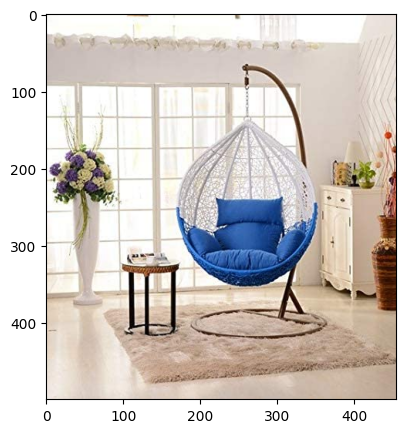

In [ ]:
image = cv2.imread('stool.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
predictor = SamPredictor(sam)
predictor.set_image(image)
masks, _, _ = predictor.predict("stool")

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

In [ ]:
masks

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 2714,
  'bbox': [218, 270, 88, 40],
  'predicted_iou': 1.0092207193374634,
  'point_coords': [[248.828125, 273.4375]],
  'stability_score': 0.9770825505256653,
  'crop_box': [0, 0, 455, 500]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 9538,
  'bbox': [355, 223, 

In [ ]:
masks.shape

AttributeError: 'list' object has no attribute 'shape'

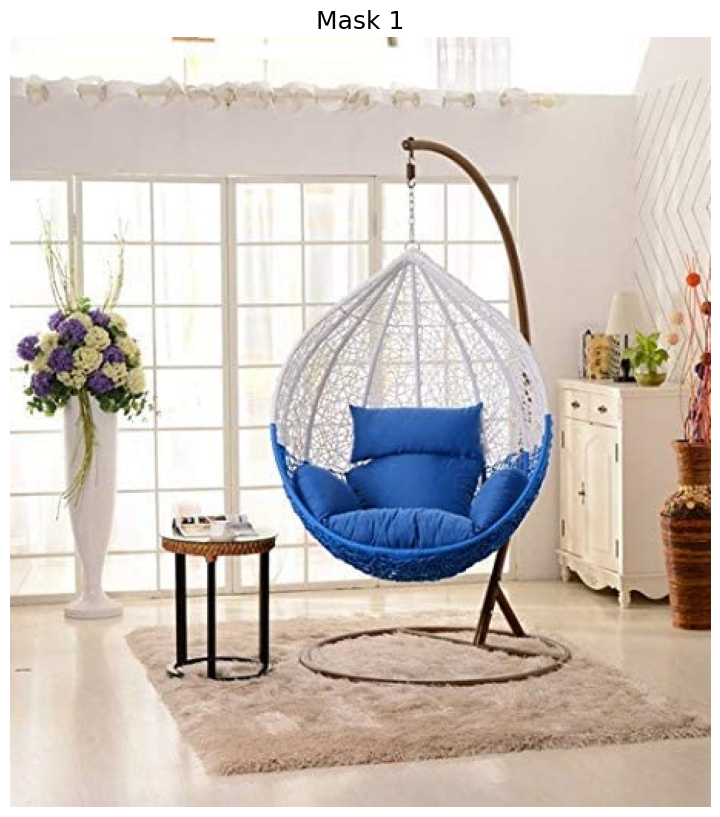

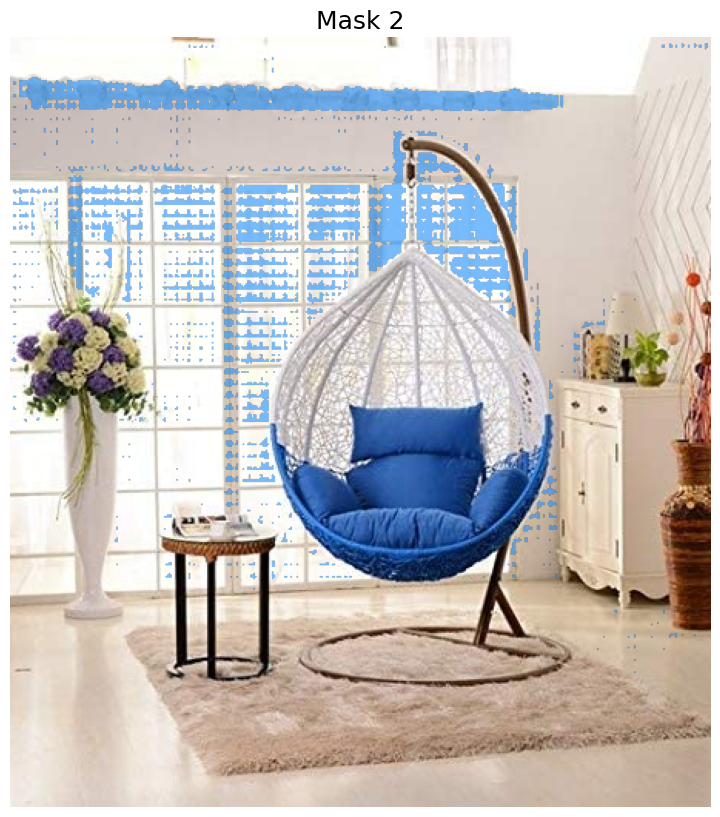

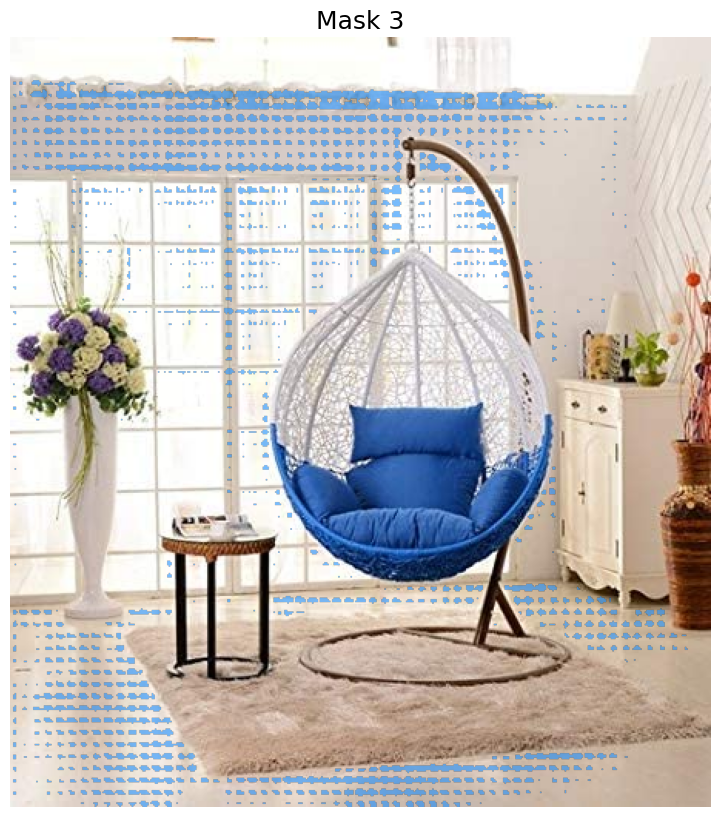

In [ ]:
for i, mask in enumerate(masks):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}", fontsize=18)
    plt.axis('off')
    plt.show()